### Original data:

+ CMS tree cover from ORNL DAAC  https://doi.org/10.3334/ORNLDAAC/1538
+ GFW tree cover 2000 & GFW lossyear  https://storage.googleapis.com/earthenginepartners-hansen/GFC-2021-v1.9/download.html
+ GFW tree cover 2010  https://glad.umd.edu/Potapov/TCC_2010/
+ NAFD 2000-2010 from ORNL DAAC  https://doi.org/10.3334/ORNLDAAC/1290
+ NLCD land cover 2001-2011 & NLCD tree cover 2011 in MRLC  https://www.mrlc.gov/data?f%5B0%5D=category%3ALand%20Cover&f%5B1%5D=category%3ATree%20Canopy&f%5B2%5D=region%3Aconus


### Additional data:

+ The State of Maryland shapefile from maryland.gov  https://data.imap.maryland.gov/datasets/maryland::maryland-political-boundaries-county-boundaries/about

### Pre-processes:

+ Project the downloaded data to Albers Conical Equal Area coodinate system
+ Clip the downloaded data to the State of Maryland, USA
+ Develop GFW and CMS forest data by converting tree cover to forest with a 30% threshold:
    * if tree cover > 30%, forest
    * if tree cover < 30%, non-forest
+ Develop NLCD forest data by extracting forests from land cover data:
    * forests include deciduous forest, evergreen forest, mix forest, and woody wetlands
+ Make the forest data binary
    * if forest, 1
    * if non-forest, 0
+ Clip the forest and tree cover data to the counties of Maryland


### Forest Area Analysis

In [1]:
import os
from osgeo import gdal, gdalconst
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

directory = '/gpfs/data1/hurttgp/gel1/quan/MD_monitoring/publish'

# read in county-level forest data
nafd_cnty_f_dir = os.path.join(directory,'data','NAFD','processed','forest_counties')
gfw_cnty_f_dir = os.path.join(directory,'data','GFW','processed','forest_counties', '2010')
cms_cnty_f_dir = os.path.join(directory,'data','CMS','processed','forest_counties')
nlcd_cnty_f_dir = os.path.join(directory,'data','NLCD','processed','forest_counties', '2011')
md = gpd.read_file(os.path.join(directory, 'spatial', 'Maryland_Political_Boundaries_-_County_Boundaries', 'MD_proj.shp'))

# read in spatial reference data
ref = gdal.Open(os.path.join(directory,'spatial','MD_spatial_reference.tif'), gdalconst.GA_ReadOnly)

cols = ref.RasterXSize
rows = ref.RasterYSize
geot = ref.GetGeoTransform()
proj = ref.GetProjection()

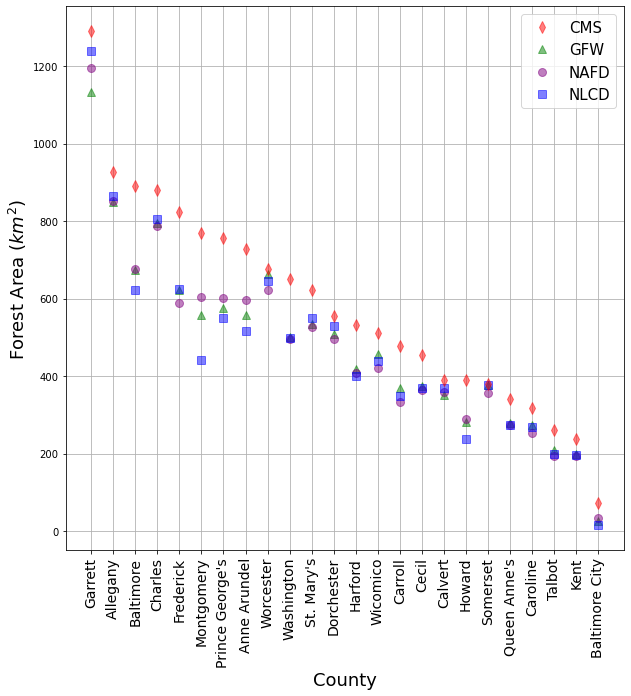

In [2]:
# create scatter plot
forest_df = pd.DataFrame(columns = ['County', 'NAFD', 'GFW', 'CMS', 'NLCD'])
for i in range(len(md)):
    name = md.iloc[i][1]+'.tif'
    nafd_cnty_f = gdal.Open(os.path.join(nafd_cnty_f_dir, name), gdalconst.GA_ReadOnly).ReadAsArray()
    gfw_cnty_f = gdal.Open(os.path.join(gfw_cnty_f_dir, name), gdalconst.GA_ReadOnly).ReadAsArray()
    cms_cnty_f = gdal.Open(os.path.join(cms_cnty_f_dir, name), gdalconst.GA_ReadOnly).ReadAsArray()
    nlcd_cnty_f = gdal.Open(os.path.join(nlcd_cnty_f_dir, name), gdalconst.GA_ReadOnly).ReadAsArray()
    
    nafd_cnty_fa = np.sum(nafd_cnty_f)*30*30/1e6 # "*30*30/1e6" converts the number of pixels to km^2. Each pixel is 30m by 30m.
    gfw_cnty_fa = np.sum(gfw_cnty_f)*30*30/1e6
    cms_cnty_fa = np.sum(cms_cnty_f)*30*30/1e6
    nlcd_cnty_fa = np.sum(nlcd_cnty_f)*30*30/1e6
    
    forest_df.loc[i] = [md.iloc[i][1]] + list((nafd_cnty_fa, gfw_cnty_fa, cms_cnty_fa, nlcd_cnty_fa))
    
forest_df.sort_values(by = 'CMS', inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(forest_df['County'], forest_df['CMS'], color='red', marker='d',markersize=8,linestyle='', alpha=0.5, label='CMS', zorder=10)
ax.plot(forest_df['County'], forest_df['GFW'], color='green', marker='^',markersize=8,linestyle='', alpha=0.5, label='GFW')
ax.plot(forest_df['County'], forest_df['NAFD'], color='purple', marker='o',markersize=8,linestyle='', alpha=0.5, label='NAFD')
ax.plot(forest_df['County'], forest_df['NLCD'], color='blue', marker='s',markersize=8,linestyle='', alpha=0.5, label='NLCD')
plt.xlabel("County", fontsize=18)
plt.ylabel("Forest Area ($km^2$)", fontsize=18)
plt.legend(prop={'size':15})
plt.xticks(rotation=90, fontsize=14)
plt.grid()
plt.show()

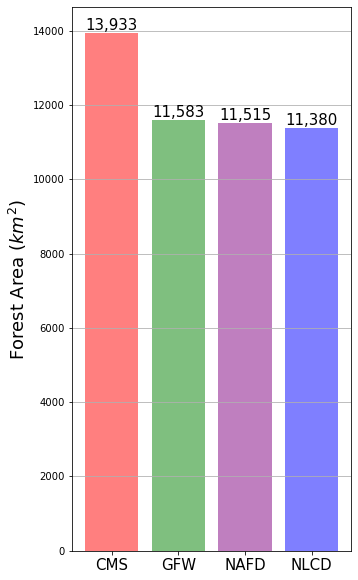

In [3]:
# create bar plot
names = ['CMS', 'GFW', 'NAFD', 'NLCD']
values = [forest_df['CMS'].sum(), forest_df['GFW'].sum(), forest_df['NAFD'].sum(), forest_df['NLCD'].sum()]
fig, ax = plt.subplots(figsize = (5, 10))
 
ax.bar(names, values, color = ['red', 'green', 'purple', 'blue'], alpha=0.5)
 
rects = ax.patches

for rect, value in zip(rects, values):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 10, "{:,}".format(round(value)), ha="center", va="bottom",fontsize=15)
    
plt.ylabel("Forest Area ($km^2$)", fontsize=18)
plt.xticks(fontsize=15 )
plt.grid(axis='y')
plt.show()

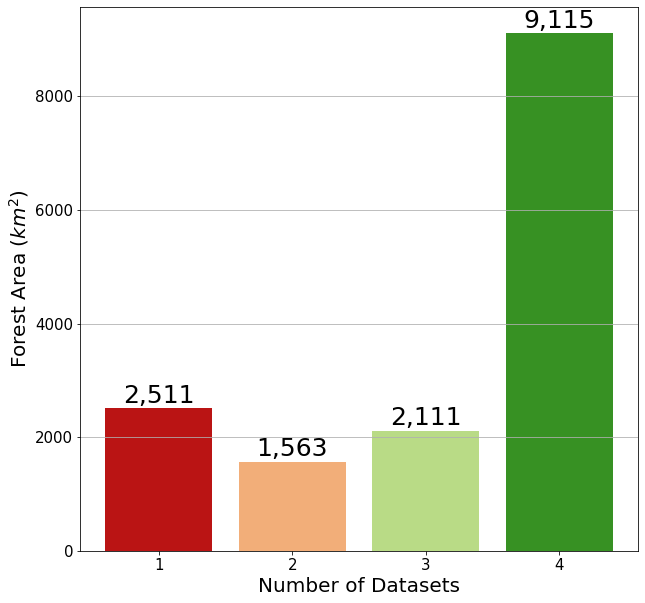

In [4]:
# read in state-level forest data
nafd_f_dir = os.path.join(directory,'data','NAFD','processed','forest2010.tif')
gfw_f_dir = os.path.join(directory,'data','GFW','processed','forest2010.tif')
cms_f_dir = os.path.join(directory,'data','CMS','processed','forest2011.tif')
nlcd_f_dir = os.path.join(directory,'data','NLCD','processed','forest2011.tif')

nafd_f = gdal.Open(os.path.join(nafd_f_dir), gdalconst.GA_ReadOnly).ReadAsArray()
gfw_f = gdal.Open(os.path.join(gfw_f_dir), gdalconst.GA_ReadOnly).ReadAsArray()
cms_f = gdal.Open(os.path.join(cms_f_dir), gdalconst.GA_ReadOnly).ReadAsArray()
nlcd_f = gdal.Open(os.path.join(nlcd_f_dir), gdalconst.GA_ReadOnly).ReadAsArray()

overlap = nafd_f+gfw_f+cms_f+nlcd_f

# save the data as a tiff file
outarray = overlap
out_dir = os.path.join(directory, 'data','Mixed','forest','overlap.tif')
driver = gdal.GetDriverByName("GTiff")
new_ds = driver.Create(out_dir, cols, rows, 1, gdal.GDT_Float32)
new_ds.SetGeoTransform(geot)
new_ds.SetProjection(proj)

outband = new_ds.GetRasterBand(1)
outband.WriteArray(outarray)
outband.FlushCache()
del new_ds

# create bar plot
uniq, counts = np.unique(overlap, return_counts = True)
names=['1', '2', '3', '4']
values = list(counts[2:]*30*30/1e6)

fig, ax = plt.subplots(figsize = (10, 10))

ax.bar(names, values, color = ['#BA1414', '#F2AE79', '#B9DB86', '#379123'])

rects = ax.patches

for rect, value in zip(rects, values):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 10, "{:,}".format(round(value)), ha="center", va="bottom",fontsize=25)

plt.yticks(fontsize=15)
plt.ylabel("Forest Area ($km^2$)", fontsize=20)
plt.xlabel("Number of Datasets", fontsize=20)
plt.xticks(fontsize=15 )
plt.grid(axis='y')
plt.show()

### Tree Cover Analysis

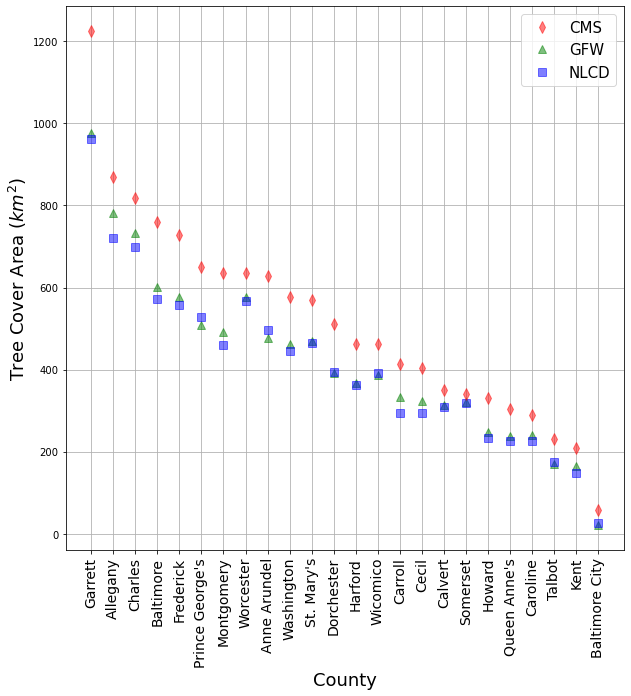

In [5]:
# read in county-level tree cover data
cms_cnty_tc_dir = os.path.join(directory,'data','CMS','processed','tc_counties')
gfw_cnty_tc_dir = os.path.join(directory,'data','GFW','processed','tc_counties', '2010')
nlcd_cnty_tc_dir = os.path.join(directory,'data','NLCD','processed','tc_counties', '2011')

# create scatter plot
tc_df = pd.DataFrame(columns = ['County', 'CMS', 'GFW', 'NLCD'])
for i in range(len(md)):
    name = md.iloc[i][1]+'.tif'
    cms_cnty_tc = gdal.Open(os.path.join(cms_cnty_tc_dir, name), gdalconst.GA_ReadOnly).ReadAsArray()
    gfw_cnty_tc = gdal.Open(os.path.join(gfw_cnty_tc_dir, name), gdalconst.GA_ReadOnly).ReadAsArray()
    nlcd_cnty_tc = gdal.Open(os.path.join(nlcd_cnty_tc_dir, name), gdalconst.GA_ReadOnly).ReadAsArray()
    
    cms_cnty_tca = np.sum(cms_cnty_tc[cms_cnty_tc>=0])*30*30/1e6/100 # "*30*30/1e6" converts # of pixels to area, "/100" convert percent to decimal
    gfw_cnty_tca = np.sum(gfw_cnty_tc[gfw_cnty_tc>=0])*30*30/1e6/100
    nlcd_cnty_tca = np.sum(nlcd_cnty_tc[nlcd_cnty_tc>=0])*30*30/1e6/100
    
    tc_df.loc[i] = [md.iloc[i][1]] + list((cms_cnty_tca, gfw_cnty_tca, nlcd_cnty_tca))

tc_df.sort_values(by = 'CMS', inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(tc_df['County'], tc_df['CMS'], color='red', marker='d',markersize=8,linestyle='', alpha=0.5, label='CMS', zorder=10)
ax.plot(tc_df['County'], tc_df['GFW'], color='green', marker='^',markersize=8,linestyle='', alpha=0.5, label='GFW')
ax.plot(tc_df['County'], tc_df['NLCD'], color='blue', marker='s',markersize=8,linestyle='', alpha=0.5, label='NLCD')
plt.xlabel("County", fontsize=18)
plt.ylabel("Tree Cover Area ($km^2$)", fontsize=18)
plt.legend(prop={'size':15})
plt.xticks(rotation=90, fontsize=14)
plt.grid()
plt.show()

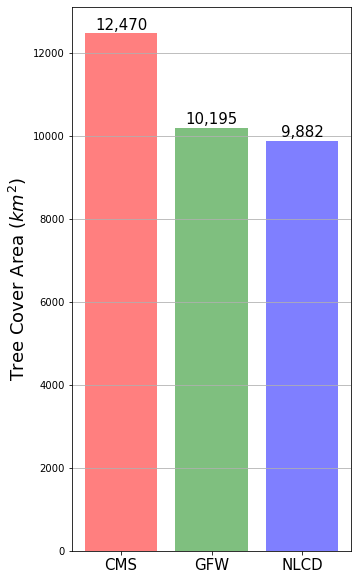

In [6]:
# read in state-level tree cover data
gfw_tc = gdal.Open(os.path.join(directory,'data','GFW','processed','treecover2010.tif'), gdalconst.GA_ReadOnly).ReadAsArray()
cms_tc = gdal.Open(os.path.join(directory,'data','CMS','processed','treecover.tif'), gdalconst.GA_ReadOnly).ReadAsArray()
nlcd_tc = gdal.Open(os.path.join(directory,'data','NLCD','processed','treecover2011.tif'), gdalconst.GA_ReadOnly).ReadAsArray()

# create bar plot
names = ['CMS', 'GFW', 'NLCD']
cms_tca = np.sum(cms_tc[cms_tc>=0]*30*30/1e6/100) 
gfw_tca = np.sum(gfw_tc[gfw_tc>=0]*30*30/1e6/100)
nlcd_tca = np.sum(nlcd_tc[nlcd_tc>=0]*30*30/1e6/100)

names = ['CMS', 'GFW', 'NLCD']
values = [cms_tca, gfw_tca, nlcd_tca]

fig, ax = plt.subplots(figsize = (5, 10))
ax.bar(names, values, color = ['red', 'green', 'blue'], alpha=0.5)
 
rects = ax.patches

for rect, value in zip(rects, values):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 10, "{:,}".format(round(value)), ha="center", va="bottom",fontsize=15)
    
plt.ylabel("Tree Cover Area ($km^2$)", fontsize=18)
plt.xticks(fontsize=15 )
plt.grid(axis='y')
plt.show()

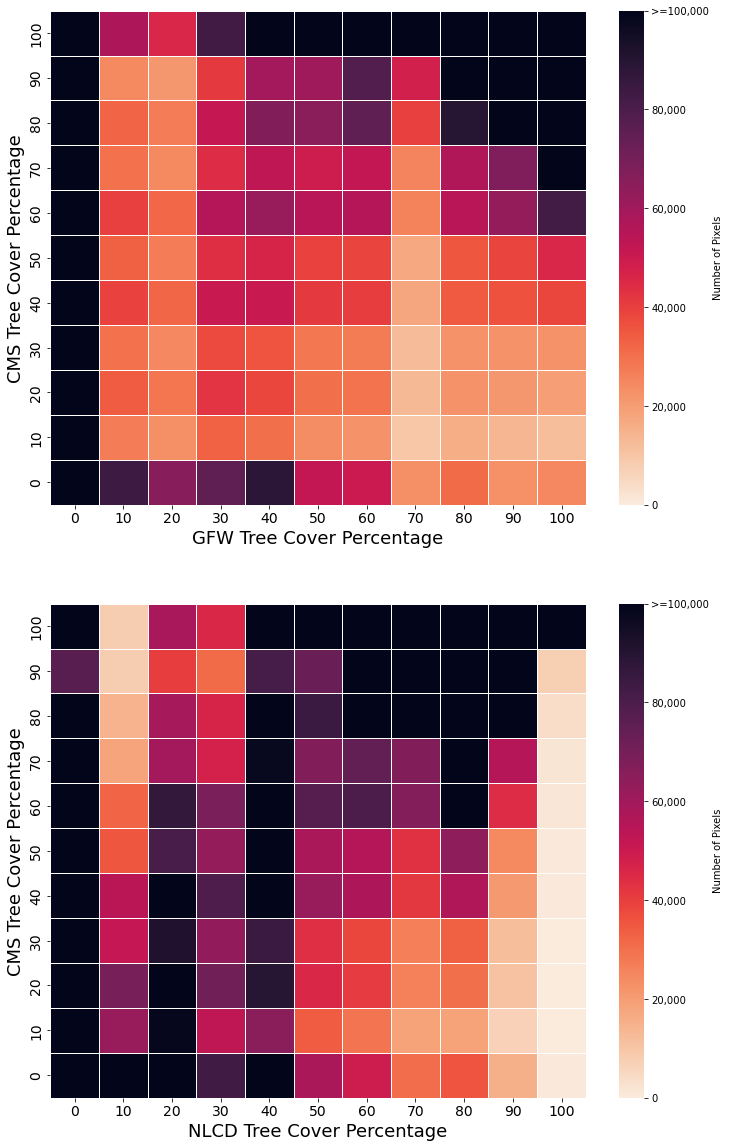

In [7]:
# create heatmaps
heat1_counts = np.zeros([11, 11])
for i in range(cms_tc.shape[0]):
    for j in range(cms_tc.shape[1]):
        if (gfw_tc[i][j] >= 0) and (cms_tc[i][j] >= 0):
            row = round((100-cms_tc[i][j])/10)
            col = round(gfw_tc[i][j]/10)
            heat1_counts[row][col] = heat1_counts[row][col]+1
            
heat1_df = pd.DataFrame(heat1_counts, index=np.arange(100,-1, -10), columns=np.arange(0, 101, 10))

heat2_counts = np.zeros([11, 11])
for i in range(cms_tc.shape[0]):
    for j in range(cms_tc.shape[1]):
        if (nlcd_tc[i][j] >= 0) and (cms_tc[i][j] >= 0):
            row = round((100-cms_tc[i][j])/10)
            col = round(nlcd_tc[i][j]/10)
            heat2_counts[row][col] = heat2_counts[row][col]+1

heat2_df = pd.DataFrame(heat2_counts, index=np.arange(100,-1, -10), columns=np.arange(0,101, 10))


fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12,20))
sns.heatmap(heat1_df, vmin=0, vmax=1e5, linewidth=0.5, ax=ax0, cmap="rocket_r", cbar_kws={'label': 'Number of Pixels'})
ax0.tick_params(axis='x', labelsize=14)
ax0.tick_params(axis='y', labelsize=14)
ax0.set_xlabel("GFW Tree Cover Percentage", fontsize=18)
ax0.set_ylabel("CMS Tree Cover Percentage", fontsize=18)
cbar0 = ax0.collections[0].colorbar
cbar0.set_ticks([0, 20000, 40000, 60000, 80000, 100000])
cbar0.set_ticklabels(['0', '20,000', '40,000', '60,000', '80,000', '>=100,000'])

sns.heatmap(heat2_df, vmin=0, vmax=1e5, linewidth=0.5, ax=ax1, cmap="rocket_r", cbar_kws={'label': 'Number of Pixels'})
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.set_xlabel("NLCD Tree Cover Percentage", fontsize=18)
ax1.set_ylabel("CMS Tree Cover Percentage", fontsize=18)
cbar1 = ax1.collections[0].colorbar
cbar1.set_ticks([0, 20000, 40000, 60000, 80000, 100000])
cbar1.set_ticklabels(['0', '20,000', '40,000', '60,000', '80,000', '>=100,000'])
plt.show()

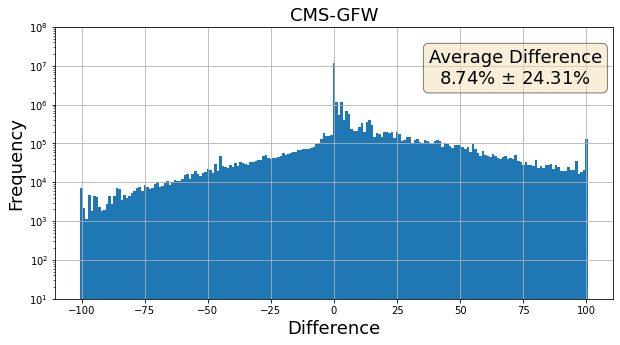

In [8]:
# remove pixels of -9999 value (outside the study area)
cms_tc_masked = np.ma.masked_where(cms_tc < 0, cms_tc)
gfw_tc_masked = np.ma.masked_where(gfw_tc < 0, gfw_tc)
cms_gfw = cms_tc_masked - gfw_tc_masked

# save the data as a tiff file
outarray = cms_gfw
out_dir = os.path.join(directory, 'data','Mixed','treecover','CMS_GFW.tif')
driver = gdal.GetDriverByName("GTiff")
new_ds = driver.Create(out_dir, cols, rows, 1, gdal.GDT_Float32)
new_ds.SetGeoTransform(geot)
new_ds.SetProjection(proj)

outband = new_ds.GetRasterBand(1)
outband.WriteArray(outarray)
outband.FlushCache()
del new_ds

# plot histogram
cms_gfw_uniq, cms_gfw_counts = np.unique(cms_gfw, return_counts=True)

cms_gfw_textstr = '\n'.join((
    r'Average Difference',
    r'%.2f%% $\pm$ %.2f%%' % (np.mean(cms_gfw),np.std(cms_gfw), )))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

fig, ax = plt.subplots(figsize=(10,5))
ax.text(0.825, 0.92, cms_gfw_textstr, transform=ax.transAxes, fontsize=18,
        verticalalignment='top',horizontalalignment='center', bbox=props)
ax.set_yscale('log')
ax.set_ylim([10e0, 10e7])
ax.set_title("CMS-GFW", fontsize=18)
ax.set_ylabel("Frequency", fontsize=18)
ax.set_xlabel("Difference", fontsize=18)
ax.grid(zorder=0)
plt.bar(cms_gfw_uniq.data[:-1], cms_gfw_counts[:-1], width=1)
plt.show()

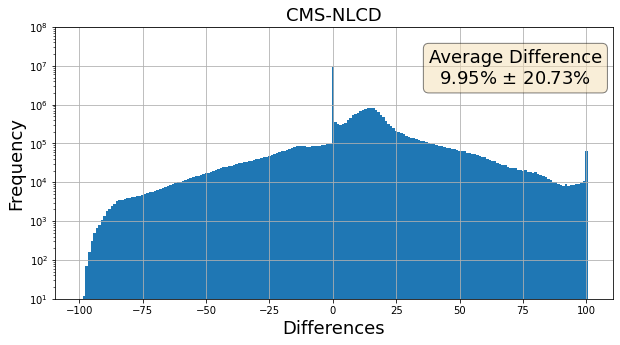

In [9]:
nlcd_tc_masked = np.ma.masked_where(nlcd_tc < 0, nlcd_tc)
cms_nlcd = cms_tc_masked - nlcd_tc_masked

# save as a tiff file
outarray = cms_gfw
out_dir = os.path.join(directory, 'data','Mixed','treecover','CMS_NLCD.tif')
driver = gdal.GetDriverByName("GTiff")
new_ds = driver.Create(out_dir, cols, rows, 1, gdal.GDT_Float32)
new_ds.SetGeoTransform(geot)
new_ds.SetProjection(proj)

outband = new_ds.GetRasterBand(1)
outband.WriteArray(outarray)
outband.FlushCache()
del new_ds

# plot histogram
cms_nlcd_uniq, cms_nlcd_counts = np.unique(cms_nlcd, return_counts=True)

cms_nlcd_textstr = '\n'.join((
    r'Average Difference',
    r'%.2f%% $\pm$ %.2f%%' % (np.mean(cms_nlcd),np.std(cms_nlcd), )))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

fig, ax = plt.subplots(figsize=(10,5))
ax.text(0.825, 0.92, cms_nlcd_textstr, transform=ax.transAxes, fontsize=18,
        verticalalignment='top',horizontalalignment='center', bbox=props)
ax.set_yscale('log')
ax.set_ylim([10e0, 10e7])
ax.set_title("CMS-NLCD", fontsize=18)
ax.set_ylabel("Frequency", fontsize=18)
ax.set_xlabel("Differences", fontsize=18)
ax.grid(zorder=0)
plt.bar(cms_nlcd_uniq.data[:-1], cms_nlcd_counts[:-1], width=1)
plt.show()

### TOF Analysis

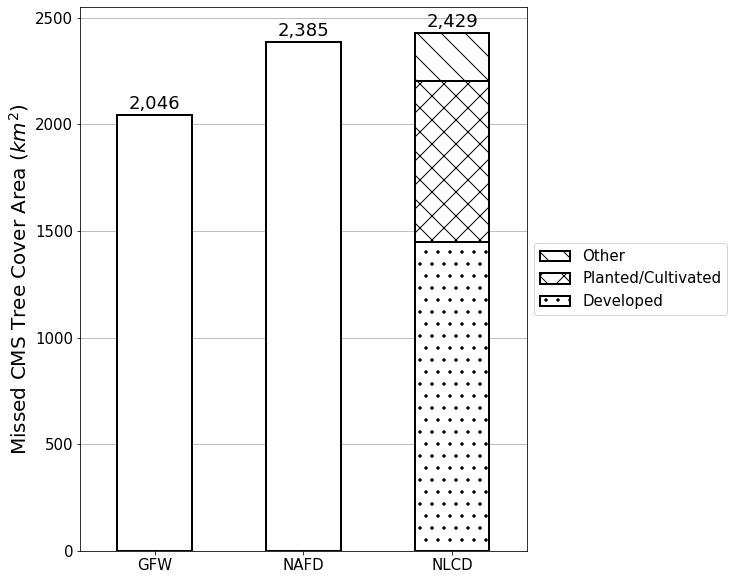

In [10]:
# GFW
cms_on_gfw = np.where((gfw_tc<=30)&(gfw_tc>=0), cms_tc - gfw_tc, 0)
gfw_tof = np.where(cms_on_gfw<0, 0, cms_on_gfw)

# NAFD
nafd2010 = gdal.Open(os.path.join(directory,'data','NAFD','processed','NAFD_2010.tif'), gdalconst.GA_ReadOnly).ReadAsArray()
nafd_f = np.where((nafd2010 == 3)|(nafd2010 == 4), 1, 0)
nafd_tof = np.where((nafd_f==0)&(cms_tc>=0), cms_tc,0)

# NLCD
nlcd_lc = gdal.Open(os.path.join(directory,'data','NLCD','processed','lc','landcover2011.tif'),gdalconst.GA_ReadOnly).ReadAsArray()
nlcd_nonf = np.where(((nlcd_lc>=40)&(nlcd_lc<=50))|(nlcd_lc==90), 0, nlcd_lc)
nlcd_nonf = np.floor(nlcd_nonf/10)*10
nlcd_nonf = np.where(((nlcd_nonf!=0)&(nlcd_nonf!=20)&(nlcd_nonf!=80)), 100, nlcd_nonf)

nlcd_tof = []
for i in np.unique(nlcd_nonf)[1:]:
    cms_on_nlcd_nonf = np.where((nlcd_nonf==i)&(cms_tc>=0), cms_tc, 0)
    nlcd_tof.append(np.sum(cms_on_nlcd_nonf)*30*30/1e6/100)

tof_df = pd.DataFrame(np.zeros((3,4)),columns=['Non-forest', 'Developed', 'Planted/Cultivated', 'Other'], 
                     index=['GFW', 'NAFD', 'NLCD'])
tof_df.iloc[0][0] = np.sum(gfw_tof)*30*30/1e6/100
tof_df.iloc[1][0] = np.sum(nafd_tof)*30*30/1e6/100
tof_df.iloc[2][1:] = nlcd_tof

# create the bar plot
tc_values = [np.sum(gfw_tof)*30*30/1e6/100, np.sum(nafd_tof)*30*30/1e6/100, np.sum(nlcd_tof)]
colors = {'Non-forest':'white', 'Developed':'#ff5500', 'Planted/Cultivated':'#dcd939', 'Other':'#72800d'}

fig, ax = plt.subplots(figsize=(10,10))
tof_df.plot(ax=ax, kind='bar', stacked=True, color='white', edgecolor='black', linewidth=2, zorder=10)

# hatch in bars
import matplotlib as mpl
bars = [thing for thing in ax.containers if isinstance(thing,mpl.container.BarContainer)]
patterns = ['','', '','.','','.','x','','x','\\','', '\\']
i = 0
for bar in bars:
    for patch in bar:
        patch.set_hatch(patterns[i])
        i = i+1

# values at the top of each bar
rects = ax.patches[0:3]
for rect, value in zip(rects, tc_values):
    ax.text(rect.get_x() + rect.get_width() / 2, value + 10, "{:,}".format(round(value)), ha="center", va="bottom",fontsize=18)

# change legend item order
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
handles, labels = plt.gca().get_legend_handles_labels()
order = np.arange(3,0,-1)
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],\
           loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15)

plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15)
plt.ylabel("Missed CMS Tree Cover Area ($km^2$)", fontsize=20)
plt.grid(axis='y')
plt.show()

### Disturbance Analysis

/tmp/ipykernel_69104/1568515574.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr_df['GFW'].iloc[1:] = gfw_loss_df['Disturbance Rate(%)']
/tmp/ipykernel_69104/1568515574.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr_df['NLCD'].iloc[1:] = nlcd_loss_df_ann['Disturbance Rate(%)']
/tmp/ipykernel_69104/1568515574.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  la_df['GFW'].iloc[1:] = gfw_loss_df['Loss Area (whole yea

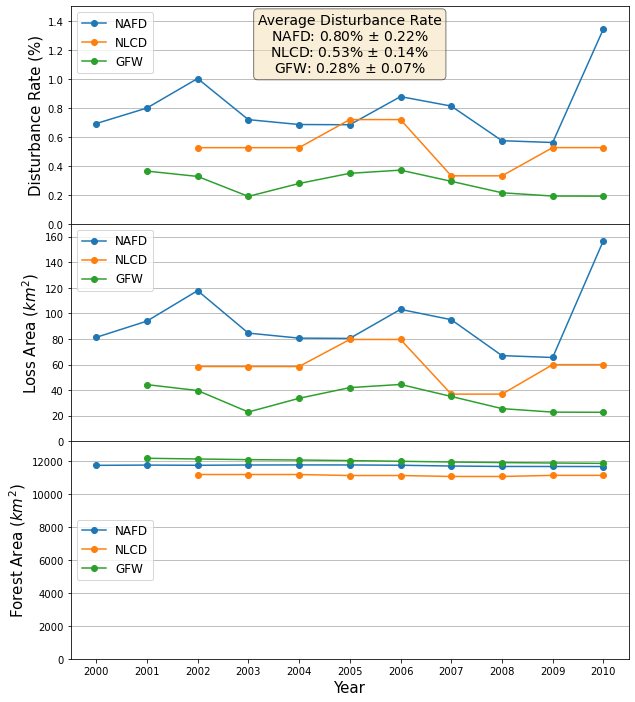

In [11]:
# GFW
gfw_lossyear = gdal.Open(os.path.join(directory,'data','GFW','processed','lossyear.tif'), gdalconst.GA_ReadOnly).ReadAsArray()
gfw_f00 = gdal.Open(os.path.join(directory,'data','GFW','processed','forest2000.tif'), gdalconst.GA_ReadOnly).ReadAsArray()

gfw_loss_df = pd.DataFrame(columns = ['Year', 'Forest Area (year-begin)', 'Loss Area (whole year)', 'Disturbance Rate(%)'])
# Assume 2000 forest is at the end of the year
gfw_fa00 = np.sum(gfw_f00)*30*30/1e6

for i in range(1, 11):
    yr = 2000 + i
    la = len(gfw_lossyear[gfw_lossyear==i])*30*30/1e6
    if i==1:
        fa = gfw_fa00
    else:
        fa = gfw_loss_df.loc[i-1]['Forest Area (year-begin)'] - gfw_loss_df.loc[i-1]['Loss Area (whole year)']
    dr = la/fa*100
    gfw_loss_df.loc[i] = list((yr, fa, la, dr)) # year, forest area, loss area, disturbance rate

gfw_loss_df.sort_index(inplace=True)


# NAFD
nafd_loss_df = pd.DataFrame(columns = ['Year', 'Forest Area (year-begin)', 'Loss Area (whole year)', 'Disturbance Rate(%)'])

for i in range(2000, 2010+1):
    nafd_i = gdal.Open(os.path.join(directory,'data','NAFD','processed','NAFD_%d.tif'%i), gdalconst.GA_ReadOnly).ReadAsArray()
    yr = i
    la = len(nafd_i[nafd_i==4])*30*30/1e6
    fa = len(nafd_i[nafd_i==3])*30*30/1e6 + la
    dr = la/fa*100
    nafd_loss_df.loc[i-15] = list((yr, fa, la, dr))
    
    
# NLCD
nlcd01 = gdal.Open(os.path.join(directory,'data','NLCD','processed','lc','landcover2001.tif'), gdalconst.GA_ReadOnly).ReadAsArray()
nlcd04 = gdal.Open(os.path.join(directory,'data','NLCD','processed','lc','landcover2004.tif'), gdalconst.GA_ReadOnly).ReadAsArray()
nlcd06 = gdal.Open(os.path.join(directory,'data','NLCD','processed','lc','landcover2006.tif'), gdalconst.GA_ReadOnly).ReadAsArray()
nlcd08 = gdal.Open(os.path.join(directory,'data','NLCD','processed','lc','landcover2008.tif'), gdalconst.GA_ReadOnly).ReadAsArray()
nlcd11 = gdal.Open(os.path.join(directory,'data','NLCD','processed','lc','landcover2011.tif'), gdalconst.GA_ReadOnly).ReadAsArray()

nlcd_loss_df = pd.DataFrame(columns = ['Year', 'Forest Area', 'Loss Area', 'Disturbance Rate(%)'])

# loss01-04
f01 = np.where(((nlcd01>=40)&(nlcd01<=50))|(nlcd01==90), 1, 0)
f01_a = np.sum(f01)*30*30/1e6

nlcd_loss_df.loc[0] = list((2001, f01_a, np.nan, np.nan))

f04 = np.where(((nlcd04>=40)&(nlcd04<=50))|(nlcd04==90), 1, 0)
f04_a = np.sum(f04)*30*30/1e6

change1 = f04-f01
loss1 = np.where(change1 < 0, 1, 0)
loss1_a = np.sum(loss1)*30*30/1e6

nlcd_loss_df.loc[1] = list((2004, f04_a, loss1_a, np.nan))

# loss04-06
f06 = np.where(((nlcd06>=40)&(nlcd06<=50))|(nlcd06==90), 1, 0)
f06_a = np.sum(f06)*30*30/1e6

change2 = f06-f04
loss2 = np.where(change2 < 0, 1, 0)
loss2_a = np.sum(loss2)*30*30/1e6

nlcd_loss_df.loc[2] = list((2006, f06_a, loss2_a, np.nan))

# loss06-08
f08 = np.where(((nlcd08>=40)&(nlcd08<=50))|(nlcd08==90), 1, 0)
f08_a = np.sum(f08)*30*30/1e6

change3 = f08-f06
loss3 = np.where(change3 < 0, 1, 0)
loss3_a = np.sum(loss3)*30*30/1e6

nlcd_loss_df.loc[3] = list((2008, f08_a, loss3_a, np.nan))

# loss08-11
f11 = np.where(((nlcd11>=40)&(nlcd11<=50))|(nlcd11==90), 1, 0)
f11_a = np.sum(f11)*30*30/1e6

change4 = f11-f08
loss4 = np.where(change4 < 0, 1, 0)
loss4_a = np.sum(loss4)*30*30/1e6

nlcd_loss_df.loc[4] = list((2011, f11_a, loss4_a, np.nan))

nlcd_loss_df['Disturbance Rate(%)'] = nlcd_loss_df['Loss Area']/nlcd_loss_df['Forest Area']*100

nlcd_loss_df_ann = pd.DataFrame(columns = ['Year', 'Forest Area (year-begin)', 'Loss Area (whole year)', 'Disturbance Rate(%)'])
nlcd_loss_df_ann.loc[0] = list((2001, np.nan, np.nan, np.nan))
nlcd_loss_df_ann.loc[1] = list((2002, nlcd_loss_df.loc[0][1], nlcd_loss_df.loc[1][2]/3, nlcd_loss_df.loc[1][3]/3))
nlcd_loss_df_ann.loc[2] = list((2003, nlcd_loss_df.loc[0][1], nlcd_loss_df.loc[1][2]/3, nlcd_loss_df.loc[1][3]/3))
nlcd_loss_df_ann.loc[3] = list((2004, nlcd_loss_df.loc[0][1], nlcd_loss_df.loc[1][2]/3, nlcd_loss_df.loc[1][3]/3))
nlcd_loss_df_ann.loc[4] = list((2005, nlcd_loss_df.loc[1][1], nlcd_loss_df.loc[2][2]/2, nlcd_loss_df.loc[2][3]/2))
nlcd_loss_df_ann.loc[5] = list((2006, nlcd_loss_df.loc[1][1], nlcd_loss_df.loc[2][2]/2, nlcd_loss_df.loc[2][3]/2))
nlcd_loss_df_ann.loc[6] = list((2007, nlcd_loss_df.loc[2][1], nlcd_loss_df.loc[3][2]/2, nlcd_loss_df.loc[3][3]/2))
nlcd_loss_df_ann.loc[7] = list((2008, nlcd_loss_df.loc[2][1], nlcd_loss_df.loc[3][2]/2, nlcd_loss_df.loc[3][3]/2))
nlcd_loss_df_ann.loc[8] = list((2009, nlcd_loss_df.loc[3][1], nlcd_loss_df.loc[4][2]/3, nlcd_loss_df.loc[4][3]/3))
nlcd_loss_df_ann.loc[9] = list((2010, nlcd_loss_df.loc[3][1], nlcd_loss_df.loc[4][2]/3, nlcd_loss_df.loc[4][3]/3))

dr_df = pd.DataFrame(columns = ['Year', 'NAFD', 'NLCD', 'GFW'])
dr_df['Year'] = nafd_loss_df['Year']
dr_df['NAFD'] = nafd_loss_df['Disturbance Rate(%)']
dr_df['GFW'].iloc[1:] = gfw_loss_df['Disturbance Rate(%)']
dr_df['NLCD'].iloc[1:] = nlcd_loss_df_ann['Disturbance Rate(%)']

la_df = pd.DataFrame(columns = ['Year', 'NAFD', 'NLCD', 'GFW'])
la_df['Year'] = nafd_loss_df['Year']
la_df['NAFD'] = nafd_loss_df['Loss Area (whole year)']
la_df['GFW'].iloc[1:] = gfw_loss_df['Loss Area (whole year)']
la_df['NLCD'].iloc[1:] = nlcd_loss_df_ann['Loss Area (whole year)']

fa_df = pd.DataFrame(columns = ['Year', 'NAFD', 'NLCD', 'GFW'])
fa_df['Year'] = nafd_loss_df['Year']
fa_df['NAFD'] = nafd_loss_df['Forest Area (year-begin)']
fa_df['GFW'].iloc[1:] = gfw_loss_df['Forest Area (year-begin)']
fa_df['NLCD'].iloc[1:] = nlcd_loss_df_ann['Forest Area (year-begin)']

textstr = '\n'.join((
    r'Average Disturbance Rate',
    r'NAFD: %.2f%% $\pm$ %.2f%%' % (dr_df.mean()[1],dr_df.std()[1], ),
    r'NLCD: %.2f%% $\pm$ %.2f%%' % (dr_df.mean()[2],dr_df.std()[2], ),
    r'GFW: %.2f%% $\pm$ %.2f%%' % (dr_df.mean()[3],dr_df.std()[3], ),))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(10,12), sharex=True)
fig.subplots_adjust(hspace=0)

dr_df.plot(x='Year', ax=ax0, marker='o')
ax0.grid(axis='y')
ax0.set_ylabel("Disturbance Rate (%)", fontsize=15)
ax0.set_ylim([0, 1.5])
ax0.text(0.5, 0.97, textstr, transform=ax0.transAxes, fontsize=14,
        verticalalignment='top',horizontalalignment='center', bbox=props)
ax0.legend(prop={'size': 12})

la_df.plot(x='Year', ax=ax1, marker='o')
ax1.grid(axis='y')
ax1.set_ylabel("Loss Area ($km^2$)", fontsize=15)
ax1.set_ylim([0, 170])
ax1.legend(prop={'size': 12})


fa_df.plot(x='Year', ax=ax2, marker='o')
ax2.grid(axis='y')
ax2.set_ylabel("Forest Area ($km^2$)", fontsize=15)
ax2.set_ylim([0, 13200])
ax2.legend(loc=6, prop={'size': 12})


plt.xlabel("Year", fontsize=15)
plt.xticks(np.arange(2000, 2011, step=1))
plt.show()

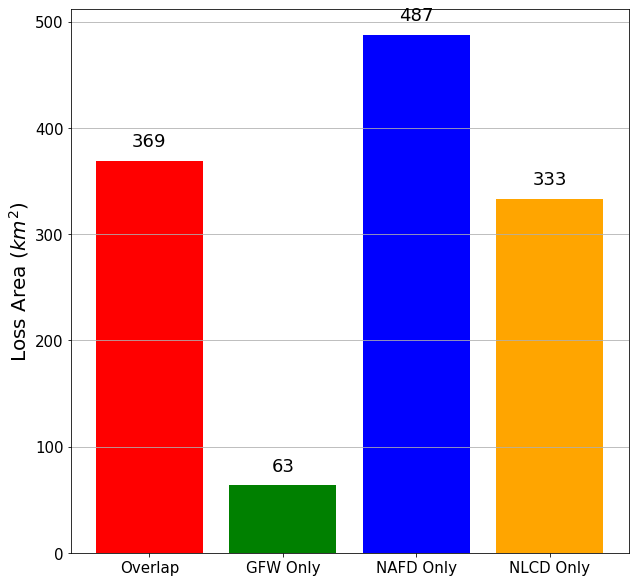

In [12]:
# GFW 10-year cumulative loss
gfw_loss_10yrs = np.where((gfw_lossyear>=1)&(gfw_lossyear<=10), 1, 0)

# NAFD 10-year cumulative loss
nafd_loss_10yrs = np.zeros(gfw_loss_10yrs.shape)

for i in range(2000, 2010):
    nafd_i = gdal.Open(os.path.join(directory,'data','NAFD','processed','NAFD_%d.tif'%i), gdalconst.GA_ReadOnly).ReadAsArray()
    nafd_loss_10yrs = np.ma.masked_where(nafd_i == 4, nafd_loss_10yrs)

nafd_loss_10yrs = nafd_loss_10yrs.filled(fill_value=1)

# NLCD 10-year cumulative loss
nlcd_loss_10yrs = loss1 + loss2 + loss3 + loss4
nlcd_loss_10yrs = np.where((nlcd_loss_10yrs>0) & (nlcd_loss_10yrs<5), 1, 0)

all_loss_10yrs = gfw_loss_10yrs*11 + nafd_loss_10yrs*12 + nlcd_loss_10yrs*13 # distinguish loss indicated by multiple datasets from loss indicated by only 1 dataset

# save the data as a  tiff file
outarray = all_loss_10yrs
out_dir = os.path.join(directory, 'data','Mixed','disturbance','GFW11_NAFD12_NLCD13.tif')
driver = gdal.GetDriverByName("GTiff")
new_ds = driver.Create(out_dir, cols, rows, 1, gdal.GDT_Float32)
new_ds.SetGeoTransform(geot)
new_ds.SetProjection(proj)

outband = new_ds.GetRasterBand(1)
outband.WriteArray(outarray)
outband.FlushCache()
del new_ds
 
# create the bar plot
uniq, counts = np.unique(all_loss_10yrs, return_counts = True)
names=['Overlap', 'GFW Only', 'NAFD Only', 'NLCD Only']
values = [sum(counts[4:])*30*30/1e6, counts[1]*30*30/1e6, counts[2]*30*30/1e6, counts[3]*30*30/1e6]

fig, ax = plt.subplots(figsize = (10, 10))

ax.bar(names, values, color = ['red', 'green', 'blue', 'orange'])
 
rects = ax.patches

for rect, value in zip(rects, values):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 10, "{:,}".format(round(value)), ha="center", va="bottom",fontsize=18)

plt.yticks(fontsize=15)
plt.ylabel("Loss Area ($km^2$)", fontsize=20)
plt.xticks(fontsize=15 )
plt.grid(axis='y')
plt.show()